# HW 2
**Eli Schwat**  
**CEWA 568**  
**Spring 2023**

In [1]:
import xarray as xr
import altair as alt
import pandas as pd
import datetime as dt
from metloom.pointdata import SnotelPointData

alt.renderers.enable("png")
alt.data_transformers.disable_max_rows()

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/metloom/pointdata/base.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


DataTransformerRegistry.enable('default')

# Problem 1

Using the observations of total precipitation and the snow pillow data (see labs above), we are going to investigate the mass balance and snow accumulation at Kettle Ponds.

## A. 

Plot a timeseries of total accumulated precipitation and total accumulated snow water equivalent from the four snow pillows. Add to your plot timeseries from the two Snotel Stations located nearby. Discuss how they match and how they differ, and why you think they differ.


### Tilden Precip Data

In [2]:
precip_xr = xr.open_dataset('../modules/data/precipitation.nc')
precip_df = precip_xr.to_dataframe().reset_index()

In [3]:
precip_df

,date,acc_prec
0,2022-11-01,0.00
1,2022-11-02,0.00
2,2022-11-03,10.90
3,2022-11-04,10.90
4,2022-11-05,11.11
...,...,...
127,2023-03-08,344.04
128,2023-03-09,344.04
129,2023-03-10,387.95
130,2023-03-11,403.39


### SoS Snow Pillow data

#### Download

In [5]:
start_date = '20221201'
end_date = '20230312'
VARIABLES = ['SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c', 'T_2m_c']
download_directory = "/data2/elilouis/sublimationofsnow/sosnoqc/"
!mkdir $download_directory

mkdir: cannot create directory ‘/data2/elilouis/sublimationofsnow/sosnoqc/’: File exists


In [6]:
import urllib
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

In [7]:
# Create a list of datetime objects for every day between the provided start_date and end_date. 
datelist = pd.date_range(
    dt.datetime.strptime(start_date, '%Y%m%d'),
    dt.datetime.strptime(end_date, '%Y%m%d'),
    freq='d'
).strftime('%Y%m%d').tolist()

# Download one daily file for each date in the datelist. 
# cache = True so that when we rerun the notebook in the future, we don't have to redownload the data.
files = [download_sos_data_day(date, download_directory, cache=True) for date in datelist]

Caching...skipping download for 20221201
Caching...skipping download for 20221202
Caching...skipping download for 20221203
Caching...skipping download for 20221204
Caching...skipping download for 20221205
Caching...skipping download for 20221206
Caching...skipping download for 20221207
Caching...skipping download for 20221208
Caching...skipping download for 20221209
Caching...skipping download for 20221210
Caching...skipping download for 20221211
Caching...skipping download for 20221212
Caching...skipping download for 20221213
Caching...skipping download for 20221214
Caching...skipping download for 20221215
Caching...skipping download for 20221216
Caching...skipping download for 20221217
Caching...skipping download for 20221218
Caching...skipping download for 20221219
Caching...skipping download for 20221220
Caching...skipping download for 20221221
Caching...skipping download for 20221222
Caching...skipping download for 20221223
Caching...skipping download for 20221224
Caching...skippi

#### Open

In [7]:
# Open up datasets from every day, extracting our VARIABLES of choice as we open individual datasets. This is so that we have a smaller dataset held 
# in computer memory.
all_datasets = [xr.open_dataset(file)[VARIABLES] for file in files[10:40]]

In [8]:
sos_dataset = xr.concat(all_datasets, dim='time')

In [9]:
sos_dataset_60min = sos_dataset.resample(time="60Min").mean()

In [10]:
sos_df = sos_dataset_60min.to_dataframe().reset_index()

### Snotel data

#### Download

In [11]:
start_date = dt.datetime(2022,12,1)
end_date = dt.datetime(2023,3,12)
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_df = snotel_point.get_daily_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.SWE]
)
butte_df = butte_df.assign(site_name = 'Butte')

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_df = snotel_point.get_daily_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.SWE]
)
schofield_df = schofield_df.assign(site_name = 'Schofield Pass')

In [12]:
snotel_df = pd.concat([butte_df, schofield_df])
snotel_df['SWE'] = snotel_df['SWE']*25.4
snotel_df['SWE_units'] = 'mm'
snotel_df = snotel_df.reset_index()

### Plot

In [13]:
precip_chart = alt.Chart(precip_df).mark_line().encode(
    alt.X("date:T"),
    alt.Y("acc_prec:Q", title='Accumulated Precipitation (mm)')
).properties(
    title = precip_xr['acc_prec'].attrs['long_name'],
    width = 800,
    height = 175
)

sos_pillow_chart = alt.Chart(sos_df.melt(['time'])).transform_filter(
    alt.FieldOneOfPredicate('variable', ['SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c'])
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q", title='SWE (mm)'),
    alt.Color("variable:N")
).properties(
    width = 800,
    height = 175
)

snotel_pillow_chart = alt.Chart(snotel_df).mark_line().encode(
    alt.X("datetime:T"),
    alt.Y("SWE:Q", title='SWE (mm)'),
    alt.Color("site_name")
).properties(
    width = 800,
    height = 175
)

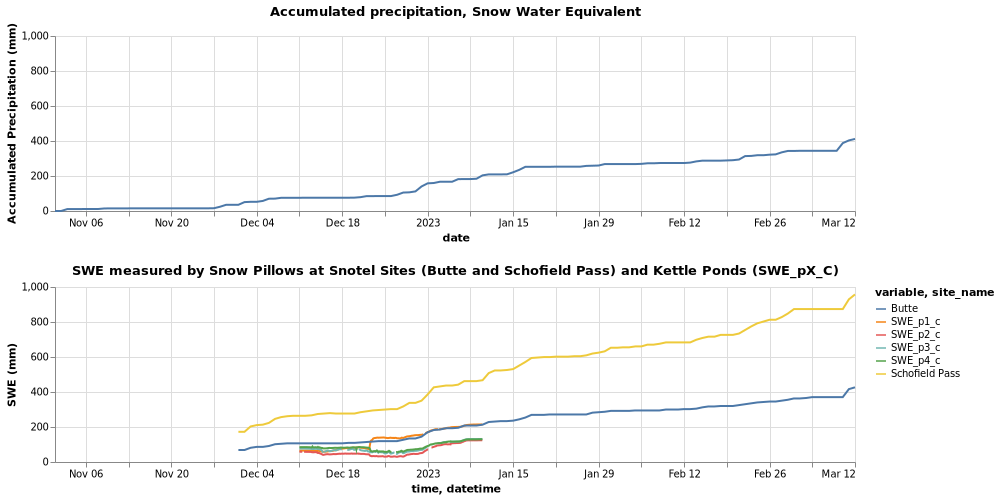

In [14]:

(precip_chart & (sos_pillow_chart + snotel_pillow_chart).properties(title='SWE measured by Snow Pillows at Snotel Sites (Butte and Schofield Pass) and Kettle Ponds (SWE_pX_C)')).resolve_scale(x='shared', y='shared', 
color='independent')

## B. 

Write out the snow mass balance equation for a control volume. Given the data you have plotted, what aspects of the mass balance equation do you have the most certainty about? The least certainty?


$ ∆SWE = Precipitation - Melt - Sublimation + ∇⋅(Blowing Snow)$

We have the most certainty about the $ ∆SWE $ component, which is measured by the continuous snow pillow data, and about the $ Precipitation $ component, which is also measured. We cannot say much about melt, sublimation, or blowing snow, besides that blowing snow probably occurs throughout the season and that melt is unlikely to occur when temps are below freezing (most of the winter).

## C. 

What factors of the mass balance are the most similar spatially? Which differ the most across different locations? Is there more variability between sites further away? Or are the four snow pillows at Kettle Ponds as different as the two sites just outside of the watershed?

$∆ SWE$ appears to be pretty consistent across the sites, although sometimes the Schofield Pass site seems to accumulate more snow during snow storms than other sites. Precipitation might be somewhat similar across sites, although we would expect, generally, higher elevation sites to get more snow (i.e. Schofield pass more than Kettle ponds which in turn gets more than Butte). There is generally more variability between sites further away from eachother. For example, all the Kettle Ponds snow pillows show pretty consistent signals, except for the SWE_p1_c pillow whichh appears to have gained snow that the other pillows did not (they may have even lost snow) around December 20th. After this event, however, the Kettle Ponds snow pillows show similar increases in SWE throughout the season. The Butte snow pillow shows remarkably similar SWE increases to the Kettle Ponds site, a notable difference being at the beginning of the snow season, most of December, when there was more snow to begin with at the Butte site. 

Overall, Butte and Kettle Ponds are the most similar of the 3 sites. Schofield pass shows quite a different SWE signal than both Kettle Ponds and Butte.

## D. 

NCAR's EOL team is committed to removing the towers at Kettle Ponds on 1 June 2023. To do that, they need to drive down a road (shown in the map above) that is currently snowed in. The road will open when the snow melts and disappears. This typically occurs in mid to late May. Using the long term records at the SNOTEL sites, and any other information you may have, to make a prediction about whether the snow will be gone (and hence the road clear) by 1 June 2023. (Note that we will assess everyone's accuracy at the end of the quarter!)

To estimate this, we will use all historical SWE data form the Butte snotel site, which is pretty close to the Gothic Road. We use the following method:

* Identify peak SWE for all years
* Find all historical years with peak SWE values within 10% of this years peak SWE
* From all these years, find average day that SWE reaches 0

Note that we will use "water years", where the latter year of the winter is used (i.e. Winter 2022-2023 is called Water Year 2023)

In [15]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_df = snotel_point.get_daily_data(
    dt.datetime(1900,12,1), dt.datetime.today(),
    [snotel_point.ALLOWED_VARIABLES.SWE]
)
butte_df = butte_df.assign(site_name = 'Butte')
butte_df = butte_df.reset_index().set_index('datetime')
butte_df = butte_df.tz_convert(None).reset_index()

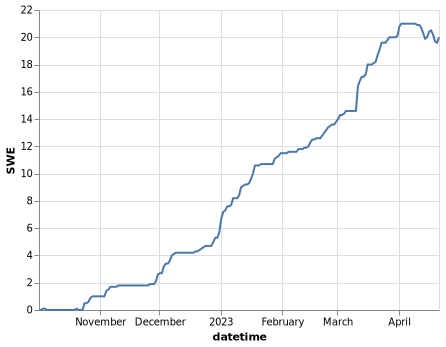

In [16]:
alt.Chart(
    butte_df[butte_df.datetime > dt.datetime(2022,10,1)]
).mark_line().encode(
    alt.X("datetime:T"),
    alt.Y("SWE:Q")
)

### Identify peak SWE (and date of peak SWE) for all years

In [ ]:
butte_df['water year'] = butte_df['datetime'].apply(lambda dt: dt.year if dt.month < 10 else dt.year+1)

In [ ]:
max_swe_df = pd.DataFrame(butte_df.set_index('datetime').groupby("water year")['SWE'].idxmax())

In [ ]:
max_swe_df['max_SWE_date'] = max_swe_df['SWE']
max_swe_df['SWE'] = max_swe_df['max_SWE_date'].apply(lambda s: butte_df.set_index('datetime').loc[s].SWE)

In [ ]:
this_year_peak_swe = max_swe_df.loc[2023]['SWE']
this_year_peak_swe

### Find all historical years with peak SWE values within 10% of this years peak SWE


In [ ]:
similar_years_df = max_swe_df[
    (max_swe_df['SWE'] < 1.1*this_year_peak_swe)
    &
    (max_swe_df['SWE'] > 0.9*this_year_peak_swe)
]

In [ ]:
similar_years_df

## For similar years, find average day that SWE reaches 0

In [ ]:
melt_out_date_df = butte_df[butte_df['water year'].isin(similar_years_df.index)]

In [ ]:
melt_out_date_df = melt_out_date_df[melt_out_date_df['SWE'] == 0]
melt_out_date_df = melt_out_date_df[melt_out_date_df['datetime'].dt.month < 10]

In [ ]:
melt_out_dates = melt_out_date_df.groupby("water year")['datetime'].min()
melt_out_dates

In [ ]:
dt.datetime(2023,1,1) + dt.timedelta(days = melt_out_dates.dt.day_of_year.mean())

My model estimates that melt out will occur on May 30th.

# Problem 2: Course Project Selection

Write a brief paragraph (3-9 sentences) describing your term project. Include the name of your partner (or specify you will be doing the project alone), the concept you will communicate or teach, and the tools you will use. If you have questions about the project, now is the time to talk to the instructor.

I have three ideas:

**Proposal 1** (more work, less overlap with research, benefits general scientific learning):
Create a lecture on the statistical mechanics behind phase changes, focusing on the details of sublimation phase changes. I think that we generally use simplified models for thermodynamics calculations (state equations). Perhaps some conditions in snowy environments complicate these simplified models. Looking into the thermodynamics/physics could maybe help us understand this stuff better. I'm not sure but it's possible we could use SoS data to the study the thermodynamics (e.g. the thermistor harp measurements we took). Applying what I learn to SoS data might be a "reach" time wise for the scope of this class project.

**Proposal 2** (less work, more overlap with research, benefits my research goals):
Repurpose some of my analyses thus far to teach a lesson about snow sublimation in the Rocky Mountains. Perform a literature review, teach what we know (state of the science), then show how the SoS project is contributing and expanding our knowledge on this topic. Maybe I could borrow from your in-progress literature review article if that's appropriate for this assignment?


**Proposal 3** (less work, more overlap with research, benefits general learning, maybe benefits others):
Teach a lecture about my favorite python plotting library Altair. We have lots of python users in our department, but very few use this library. I think its an awesome tool. I've been intending to present to the Mtn Hydro group about it for fun so doing this as a class project kills two birds with one stone.